In [1]:
from dotenv import load_dotenv
from langchain_core.messages import HumanMessage, AnyMessage
from langgraph.graph.message import add_messages
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated, List
from IPython.display import display, Image
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langgraph.errors import NodeInterrupt

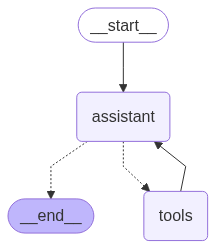

In [2]:
model = ChatGroq(model = "llama-3.1-8b-instant",temperature=0)

class State(TypedDict):
    messages: Annotated[List[AnyMessage],add_messages]
    
def multiply(a:int,b:int) -> int:
    """
    Multiply two numbers a and b
    """
    return a*b

def add(a:int,b:int) -> int:
    """
    Add two numbers a and b
    """
    return a+b

def divide(a:int,b:int) -> int:
    """
    Divide two numbers a and b
    """
    return int(a/b)

tools = [multiply,add,divide]
llm_with_tools = model.bind_tools(tools)
memory = MemorySaver()

def assistant(state:State):
    message_str = state["messages"][-1].content
    if "substract" in message_str:
        raise NodeInterrupt("substractions not supported - change instruction")
    
    return {"messages":[llm_with_tools.invoke(state['messages'])]}

builder = StateGraph(State)
builder.add_node("assistant",assistant)
builder.add_node("tools",ToolNode(tools))


builder.add_edge(START,"assistant")
builder.add_conditional_edges("assistant",tools_condition)
builder.add_edge("tools","assistant")

graph = builder.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))

In [3]:
config = {"configurable":{"thread_id":"first"}}
for chunk in graph.stream({"messages":"What is 4 plus 3 ?"},config=config,stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

What is 4 plus 3 ?
================================== Ai Message ==================================
Tool Calls:
  add (hqgrnwwvs)
 Call ID: hqgrnwwvs
  Args:
    a: 4
    b: 3
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The result of 4 plus 3 is 7.


In [ ]:
config = {"configurable":{"thread_id":"first"}}
for chunk in graph.stream({"messages":"What will we get when substract 9 from result ?"},config=config,stream_mode="values"):
    chunk["messages"][-1].pretty_print()

In [ ]:
state = graph.get_state(config)
print(state.next)

In [ ]:
print(state.tasks)

In [ ]:
graph.update_state(config,{"messages":"What will we get when 9 is added to result ?"})

In [ ]:
for chunk in graph.stream(None,config=config,stream_mode="values"):
    chunk["messages"][-1].pretty_print()

In [ ]:
config = {"configurable":{"thread_id":"fourth"}}
user_query = "add 2 and 3 "

for chunk in graph.stream({"messages":user_query},config=config,stream_mode="values"):
        chunk["messages"][-1].pretty_print()
            
user_input = input("Do you want to edit your state ? Press 'yes' for Yes")
if user_input == 'yes':
    user_input = input("Enter your update message")
    graph.update_state(config,{"messages":[HumanMessage(user_input)]},as_node="human_feedback")
    
    for chunk in graph.stream(None,config=config,stream_mode="values"):
        chunk["messages"][-1].pretty_print()
    
else:
    for chunk in graph.stream(None,config=config,stream_mode="values"):
        chunk["messages"][-1].pretty_print()

In [ ]:
for chunk in graph.stream(None,config=config,stream_mode="values"):
    chunk["messages"][-1].pretty_print()

In [4]:
result = graph.get_state(config = {"configurable":{"thread_id":"first"}})
result

StateSnapshot(values={'messages': [HumanMessage(content='What is 4 plus 3 ?', additional_kwargs={}, response_metadata={}, id='8f4f5aee-1152-4c4d-bf52-ae8633f82da9'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'hqgrnwwvs', 'function': {'arguments': '{"a":4,"b":3}', 'name': 'add'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 342, 'total_tokens': 360, 'completion_time': 0.024, 'prompt_time': 0.020280677, 'queue_time': 0.052503562000000004, 'total_time': 0.044280677}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_510c177af0', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--4516ef98-23e6-47e3-a802-5d249e303aa8-0', tool_calls=[{'name': 'add', 'args': {'a': 4, 'b': 3}, 'id': 'hqgrnwwvs', 'type': 'tool_call'}], usage_metadata={'input_tokens': 342, 'output_tokens': 18, 'total_tokens': 360}), ToolMessage(content='7', name='add', id='5cca8c6e-2762-4cb4-8832-0018bef64ed8', tool_call_id='hqgrnww

In [7]:
result = graph.get_state_history(config={"configurable":{"thread_id":"first"}})

In [13]:
result = list(result)
config = result[-2].config
config

{'configurable': {'thread_id': 'first',
  'checkpoint_ns': '',
  'checkpoint_id': '1f058ad3-f727-6680-8000-2e0734ce2a39'}}

In [19]:
result[-2].values['messages'][0].id

'8f4f5aee-1152-4c4d-bf52-ae8633f82da9'

In [14]:
## rerun
for chunk in graph.stream(None,config=config,stream_mode="values"):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

What is 4 plus 3 ?
================================== Ai Message ==================================
Tool Calls:
  add (m321atwbx)
 Call ID: m321atwbx
  Args:
    a: 4
    b: 3
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The result of 4 plus 3 is 7.


In [20]:
fork_config = graph.update_state(config=config,
                                 values={"messages":[HumanMessage("what is the final output when we add 5 and 8, then multipy 2 to the sum",id=result[-2].values['messages'][0].id)]})

In [21]:
fork_config

{'configurable': {'thread_id': 'first',
  'checkpoint_ns': '',
  'checkpoint_id': '1f058aea-c7f9-6ed2-8001-e9d2823b13ba'}}

In [22]:
for chunk in graph.stream(None,config=fork_config,stream_mode="values"):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

what is the final output when we add 5 and 8, then multipy 2 to the sum
================================== Ai Message ==================================
Tool Calls:
  add (sryqnzvbg)
 Call ID: sryqnzvbg
  Args:
    a: 5
    b: 8
  multiply (qxt2z0wh6)
 Call ID: qxt2z0wh6
  Args:
    a: 13
    b: 2
================================= Tool Message =================================
Name: multiply

26
================================== Ai Message ==================================

The final output is 26.


In [23]:
result = graph.get_state_history(config={"configurable":{"thread_id":"first"}})
result = list(result)
print(len(result))

12


In [24]:
graph.get_state(config={"configurable":{"thread_id":"first"}})

StateSnapshot(values={'messages': [HumanMessage(content='what is the final output when we add 5 and 8, then multipy 2 to the sum', additional_kwargs={}, response_metadata={}, id='8f4f5aee-1152-4c4d-bf52-ae8633f82da9'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'sryqnzvbg', 'function': {'arguments': '{"a":5,"b":8}', 'name': 'add'}, 'type': 'function'}, {'id': 'qxt2z0wh6', 'function': {'arguments': '{"a":13,"b":2}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 36, 'prompt_tokens': 356, 'total_tokens': 392, 'completion_time': 0.068742318, 'prompt_time': 0.021056571, 'queue_time': 0.050757098, 'total_time': 0.089798889}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_510c177af0', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--5b594640-bd32-440f-b99d-6fd62e0db801-0', tool_calls=[{'name': 'add', 'args': {'a': 5, 'b': 8}, 'id': 'sryqnzvbg', 'type': 'tool_call'}, {'name': 'multiply', 'args'

In [ ]:
# config = {"configurable":{"thread_id":"second"}}
# while True:    
#     user_query = input("Enter you Query")
#     if user_query != "quit":     
#         for chunk in graph.stream({"messages":user_query},config=config,stream_mode="values"):
#             chunk["messages"][-1].pretty_print()
            
#         user_input = input("Do you want to continue with tool call ? Press 'N' for No")
#         if user_input == 'N':
#             break
#         else:
#             for chunk in graph.stream(None,config=config,stream_mode="values"):
#                 chunk["messages"][-1].pretty_print()
#     else:
#         break

In [25]:
load_dotenv()

True

In [35]:
from langchain_community.tools import TavilySearchResults
from langchain.document_loaders import WikipediaLoader

In [41]:
tavilly = TavilySearchResults()
result = tavilly.invoke("who is donald trump ? ")
result = "/n".join([cn['content'] for cn in result])

In [30]:
print(result)

Donald John Trump (born June 14, 1946) is an American politician, media personality, and businessman who is the 47th president of the United States. A member of the Republican Party "Republican Party (United States)"), he served as the 45th president from 2017 to 2021. [...] |  v  t  e Donald Trump |
| --- |
|  45th (2017–2021) and 47th (2025–present) President of the United States | [...] | In office January 20, 2017– January 20, 2021 |
| Vice President | Mike Pence |
| Preceded by | Barack Obama |
| Succeeded by | Joe Biden |
|  |
| Personal details |
| Born | Donald John Trump (1946-06-14) June 14, 1946 (age 79) Queens, New York City, U.S. |
| Political party | Republican "Republican Party (United States)") (1987–1999, 2009–2011, 2012–present) |/nBiography Host
Biography Host

Copyright ©2025 Biography Host

donaldtrump

### Quick Wiki

# Donald Trump | Biography

Donald Trump, born on June 14, 1946, in Queens, New York, is a prominent entrepreneur, author, and the 45th president of

In [42]:
type(result)

str

In [40]:
wikipedia = WikipediaLoader("who is Trump",load_max_docs=2).load()
"/n".join([doc.metadata['summary'] for doc in wikipedia])

'A major aspect of Donald Trump\'s presidential election campaigns, in his 2016, 2020, and 2024 campaigns, was unauthorized use of music at his prominent and frequent political rallies. Below are musicians who have voiced opposition to their music being used by Trump at his rallies, or for other political purposes, and the actions they took in response to their music\'s use.\nSeparately to the individual cases below, a group of artists including Mick Jagger, Lorde, Sia, Blondie, Sheryl Crow, Green Day, Lionel Richie, Elvis Costello, Keith Richards, Steven Tyler and Rosanne Cash in collaboration with the Artist Rights Alliance, have signed a letter demanding that politicians seek permission before playing their music at campaign rallies and public events. Trump\'s use of music without permission has become the subject of satire, with The Onion claiming that the estate of Irving Berlin was suing Trump for his glockenspiel rendition of "God Bless America", and that the Francis Scott Key e